In [1]:
import pandas as pd
import numpy as np
import os 

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV 

import src.features.feature_selection as fsel

In [2]:
input_path = os.path.join('..\data\datasets\csv_files','2016-2019-v2.csv')
df = pd.read_csv(input_path)

df.head(3)

,period,period_type,period_time,game_seconds,gameID,attacking_team_id,attacking_team_name,home_team,shooter,goalie,...,powerplay_duration,home_team_players,away_team_players,distance_to_net,shot_angle,is_goal,is_empty_net,rebound,angle_change,speed
0,1,REGULAR,01:11,71,2016020001,10,Toronto Maple Leafs,Ottawa Senators,Mitchell Marner,Craig Anderson,...,0,5,5,13.0,23.0,0,0,False,0.0,17.088007
1,1,REGULAR,02:53,173,2016020001,9,Ottawa Senators,Ottawa Senators,Chris Kelly,Frederik Andersen,...,0,5,5,13.0,77.0,0,0,False,0.0,7.343024
2,1,REGULAR,04:01,241,2016020001,9,Ottawa Senators,Ottawa Senators,Cody Ceci,Frederik Andersen,...,0,5,5,76.0,-30.0,0,0,False,0.0,5.684341


In [3]:
df = fsel.remove_nan_from_strength(df)

In [4]:
categorical_columns_1 = ['period_type', 'attacking_team_name', 'shooter', 'goalie', 'rebound', 'last_event_type', 'home_team']
shot_type_classified = [['Wrap-around',0], ['Slap Shot', 1], ['Snap Shot', 2], ['Wrist Shot', 3], ['Backhand', 4], ['Deflected', 5], ['Tip-In',6]]
strength_classified = [['Short Handed',0], ['Even', 1], ['Power Play', 2]]

In [5]:
df = df.dropna()
df = fsel.encode_categorical_features(df, categorical_columns_1, shot_type_classified, strength_classified)

In [6]:
X = df.drop(columns=['is_goal', 'period_time'])
Y = df['is_goal']

# On récupère le dataset avec les K-meilleures caractéristiques
X_Kbest, Kbest_features = fsel.get_features_KBest(X, Y, 10)

c:\Users\Ulrich TEDONGMO\miniconda3\envs\IFT6758-Project\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Ulrich TEDONGMO\miniconda3\envs\IFT6758-Project\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_Kbest, Y, test_size = 0.2, random_state = 42 
)

MLP with KBest

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [1e-3, 1e-4, 1e-5],
}

# Créez un modèle de réseau neuronal
model = MLPClassifier(max_iter=1000)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10,
                                   scoring='f1', cv=5, verbose=1, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Accédez au meilleur modèle trouvé par la recherche aléatoire
best_model = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
print('best params', random_search.best_params_)

best params {'hidden_layer_sizes': (100, 50), 'alpha': 0.0001}


In [11]:
random_search.best_params_

{'hidden_layer_sizes': (100, 50), 'alpha': 0.0001}

In [12]:
best_model

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

In [13]:
y_pred_1 = best_model.predict(X_val_scaled)

In [14]:
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

In [15]:
from  src.features.q3_plots import *

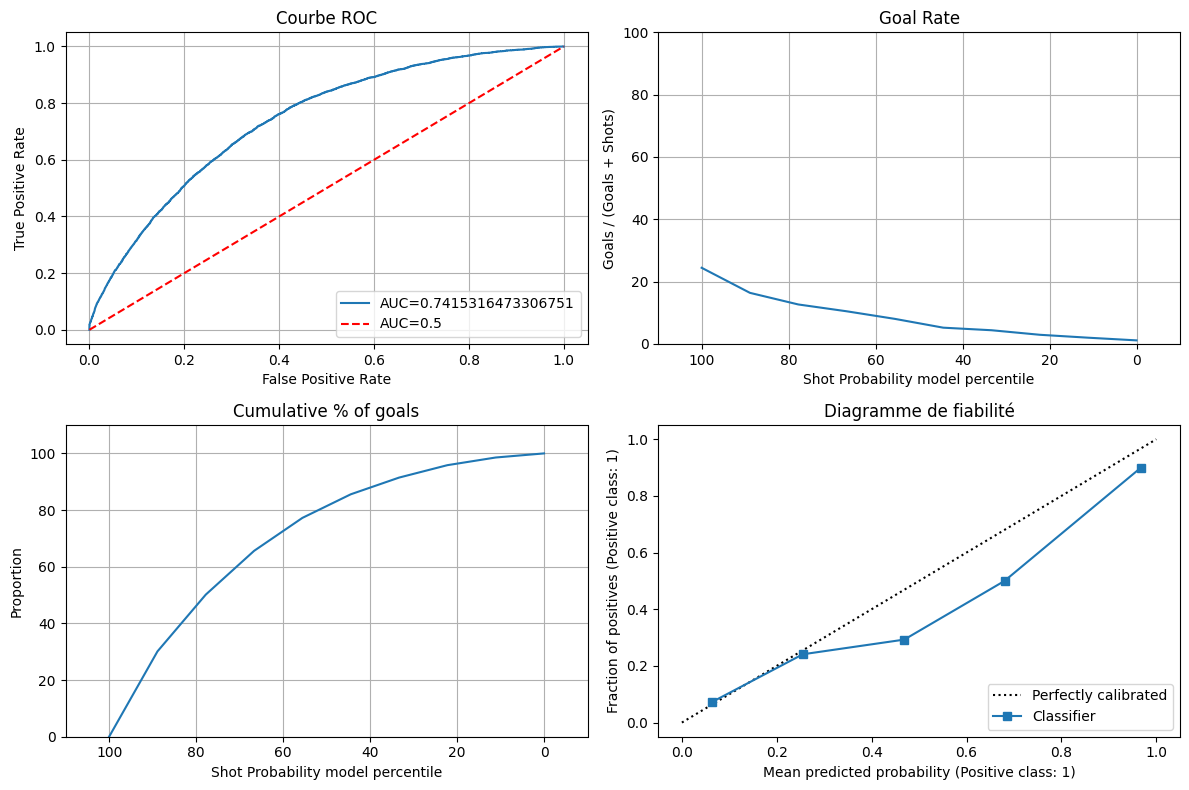

In [16]:
plot_metrics(y_val.values, y_pred_proba)

In [17]:
print("Accuracy_score :",accuracy_score(y_pred_1, y_val))
print("Recall score :" , recall_score(y_pred_1, y_val))
print("F1-score :" , f1_score(y_pred_1, y_val))
print("Roc_auc :", roc_auc_score(y_pred_1, y_val))
print(confusion_matrix(y_pred_1, y_val))

Accuracy_score : 0.9130930873823334
Recall score : 0.645
F1-score : 0.04493207941483803
Roc_auc : 0.7794727512638708
[[57489  5413]
 [   71   129]]
